# Clustering and the K-means Algorithm

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Introduction

This notebook introduces [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis) and one of the most common algorithms for it, [k-means](https://en.wikipedia.org/wiki/K-means_clustering).

It also introduces 

* Jupyter, which is a tool for creating notebooks like this that contain text, code, and results;

* NumPy, which we'll use to perform array operations;

* Pandas, which we'll use to read and clean the data file; and

* scikit-learn, which provides an implementation of k-means.

I will proceed "top-down"; that is, we'll use scikit-learn first, then we'll open the hood and see how it works.

But first, let me introduce myself.

### Bio

I am a professor at [Olin College](http://www.olin.edu/), which is a small engineering school near Boston, Massachusetts.

Olin was created in 1999 with the mission to transform engineering education.

In [1]:
%%html
<iframe src="https://www.google.com/maps/embed?pb=!1m14!1m8!1m3!1d1512.1750667940496!2d-71.26457056946273!3d42.29270982134376!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x0%3A0xa038229eeed8c35b!2sOlin%20College%20of%20Engineering!5e1!3m2!1sen!2sus!4v1594232142090!5m2!1sen!2sus" width="600" height="450" frameborder="0" style="border:0;" allowfullscreen="" aria-hidden="false" tabindex="0"></iframe>

I have been at Olin since 2003.  I teach classes related to software, data science, Bayesian statistics, and physical modeling.

I have written several books on these topics, including *Think Python* and *Think Stats*.  Most are published by O'Reilly Media, which is famous for putting animals on their covers:

<img src="https://greenteapress.com/covers/think_python_cover.jpeg">

But all of them are freely available from [Green Tea Press](https://greenteapress.com/wp/).

Finally, I write a blog about Data Science and related topics, called [Probably Overthinking It](https://www.allendowney.com/blog/).

## Jupyter and Colab

Jupyter is a tool for writing notebooks that contain text, code, and results.

You can install Jupyter on your own computer, but can also use services like Colab that run the notebook for you.
In that case, you don't have to install anything; you just need a browser.

A notebook contains:

* Text cells, which contain text in Markdown or HTML, and

* Code cell, which contain code in Python or one of about 100 other languages.

This is a text cell; the one below is a code cell.

In [2]:
print('Hello, Jupyter')

Hello, Jupyter


On Colab, code cells have a triangle "Play" icon on the left side.  You can press it to run the code in the cell.

If you select a cell by clicking on it, you can also run it by pressing Shift-Enter.

As an exercise:

1. Run the `print` statement in the previous cell.
2. Modify the code in that cell and run it again.
3. Run the next cell, which imports the Python modules we'll use later.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Also run the following cell, which defines a function we'll use.

In [4]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Clustering

Cluster analysis is a set of tools for looking at data and 

* Discovering groups, species, or categories,

* Defining boundaries between groups.

It is a form of "unsupervised" learning, which means that the only input is the dataset itself; the algorithm is not given any correct examples to learn from.

As an example, I'll used data collected and made available by Dr. Kristen Gorman at the Palmer Long-Term Ecological Research Station in Antarctica.

This dataset was published to support this article: Gorman, Williams, and Fraser, ["Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus *Pygoscelis*)"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081), March 2014.

The following cell downloads the raw data.

In [5]:
# Load the data files from https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

import os

if not os.path.exists('penguins_raw.csv'):
    !wget https://github.com/allisonhorst/palmerpenguins/raw/master/inst/extdata/penguins_raw.csv

The dataset is stored in a CSV file, which contains one row for each penguin and one column for each variable.

I'll use Pandas to read the CSV file and put the results in a `DataFrame`.

In [6]:
df = pd.read_csv('penguins_raw.csv')
df.shape

(344, 17)

A `DataFrame` is like a 2-D array, but it also contains names for the columns and labels for the rows.

The `shape` of the `DataFrame` is the number of rows and columns.

The `head` method displays the first few rows.

In [7]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


Three species of penguins are represented in the dataset: Adelie, Chinstrap and Gentoo, as shown in this illustration (by Allison Horst, available under the [CC-BY](https://creativecommons.org/licenses/by/2.0/) license):

<img width="400" src="https://pbs.twimg.com/media/EaAWkZ0U4AA1CQf?format=jpg&name=4096x4096">

In this dataset we are told that there are three species, and we are told which species each penguin belongs to.
But for purposes of clustering, we'll pretend we don't have this information, and we'll see whether the algorithm "discovers" the different species.

The measurements we'll use are:

* Body Mass in grams (g).

* Flipper Length in millimeters (mm).

* Culmen Length in millimeters.  

* Culmen Depth in millimeters.

If you are not familiar with the word "culmen", it refers to the [top margin of the beak](https://en.wikipedia.org/wiki/Bird_measurement#Culmen), as shown in the following illustration (also by Allison Horst):

<img width="400" src="https://pbs.twimg.com/media/EaAXQn8U4AAoKUj?format=jpg&name=4096x4096">

This might seem like an artificial exercise.  If we already know that there are three species, why are we trying to discover them?

For now, I'll just say that it's a learning example.  But let's come back to this question: what is unsupervised clustering good for?

## Distributions of measurements

The measurements we have will be most useful for clustering if there are substantial differences between species and small variation within species.  To see whether that is true, and to what degree, I will plot 

For convenience, I'll create a new column, called `Species2`, that contains a shorter version of the species names.

In [8]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

The following function takes the `DataFrame` and a column name, and returns a dictionary that maps from each species name to a `Cdf` of the values in the given column. 

In [159]:
grouped = df.groupby('Species2')
type(grouped)

pandas.core.groupby.generic.DataFrameGroupBy

The result is a `GroupBy` object that contains the three groups and their names.

In [10]:
for name, group in grouped:
    print(name, len(group))

Adelie 152
Chinstrap 68
Gentoo 124


We can use the `GroupBy` object to extract a column, like flipper length, from each group and compute its mean.

In [11]:
varname = 'Flipper Length (mm)'

for name, group in grouped:
    print(name, group[varname].mean())

Adelie 189.95364238410596
Chinstrap 195.8235294117647
Gentoo 217.1869918699187


We can also use it to display the distribution of values for each group.

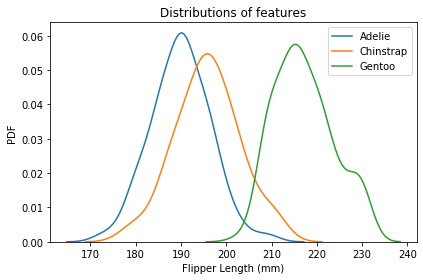

In [12]:
for name, group in grouped:
    sns.kdeplot(group[varname], label=name)
    
decorate(xlabel=varname,
         ylabel='PDF',
         title='Distributions of features')

`kdeplot` uses [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) to make a smooth histogram of the values.

It looks like we can use flipper length to identify Gentoo penguins, but not to distinguish the other two species.

I'll wrap the previous steps in a function.

In [160]:
def make_kdeplots(df, varname):
    """Make a KDE plot for each species.
    
    df: DataFrame
    varname: string column name
    by: string column name
    
    returns: dictionary from species name to Cdf
    """
    grouped = df.groupby('Species2')
    for name, group in grouped:
        sns.kdeplot(group[varname], label=name)
    
    decorate(xlabel=varname,
         ylabel='PDF',
         title='Distributions of features')

Now we can use it to explore other features, like culmen length.

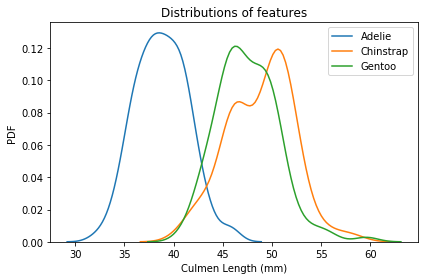

In [14]:
make_kdeplots(df, 'Culmen Length (mm)')

It looks like we can use culmen length to identify Adelie penguins,

**Exercise:** Use `make_kdeplots` to display the distributions of one of the other two features:

* `'Body Mass (g)'`
* `'Culmen Depth (mm)'`

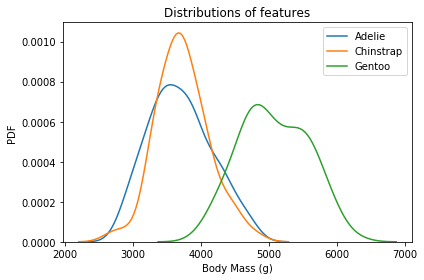

In [161]:
make_kdeplots(df, 'Body Mass (g)')

## Scatter plot

If we can identify Gentoo penguins by flipper length and Adelie penguins by culmen length, maybe we can combine these variables to identify all three species. 

I'll start by making a scatter plot of the data.

In [162]:
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
var3 = 'Culmen Depth (mm)'
var4 = 'Body Mass (g)'

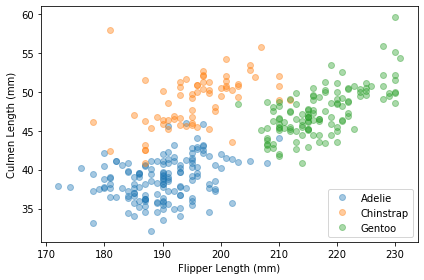

In [163]:
for name, group in grouped:
    plt.plot(group[var1], group[var2], 
             'o', alpha=0.4, label=name)
    
decorate(xlabel=var1, ylabel=var2)

Using those two features, we can divide the penguins into clusters with not much overlap.

We're going to make lots of scatter plots, so let's wrap that code in a function.

And we'll generalize it to take `by` as a parameter, so we can group by any column, not just `Species2`.

In [18]:
def scatterplot(df, var1, var2, by):
    """Make a scatter plot.
    
    df: DataFrame
    var1: string column name, x-axis
    var2: string column name, y-axis
    by: string column name, groupby
    """
    grouped = df.groupby(by)
    for name, group in grouped:
        plt.plot(group[var1], group[var2], 
                 'o', alpha=0.4, label=name)
    
    decorate(xlabel=var1, ylabel=var2)

Here's a scatter plot of flipper and culmen length for the three species.

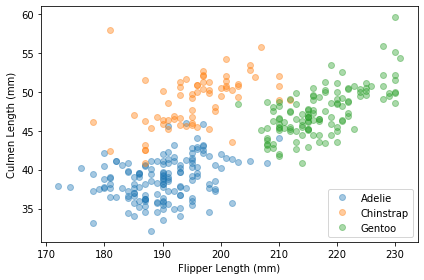

In [19]:
scatterplot(df, var1, var2, 'Species2')

Now, let's pretend we don't know anything about the different species, and we'll see whether we can rediscover these clusters.

To see what the problem looks like, I'll add a column of labels to the `DataFrame` and set it to 0 for all penguins.

In [20]:
df['labels'] = 0

Now if we group by label, there's only one big cluster.

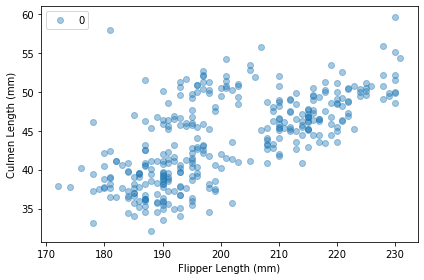

In [21]:
scatterplot(df, var1, var2, 'labels')

Let's see what happens if we run k-means clustering on this data.

## Clustering

First I'll use the implementation of k-means in scikit-learn; then we'll write our own implementation.

In the dataset, we have 344 penguins and 19 variables.

In [22]:
df.shape

(344, 19)

But some of the variables are NaN, which indicates missing data.

So I'll use `dropna` to drop any rows that have missing data for the two features we're going to use, flipper length and culmen length.

In [23]:
features = [var1, var2]
data = df.dropna(subset=features).copy()
data.shape

(342, 19)

I'll extract just those two columns as a NumPy array.

In [24]:
M = data[features].to_numpy()

Now we can use `KMeans` to identify the clusters.

`n_clusters` indicates how many cluster we want; this parameter is the $k$ the algorithm is named for.

In [124]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(M)
type(kmeans)

sklearn.cluster._kmeans.KMeans

The result is an object that contains the center of each cluster and a sequence of labels that indicates which cluster each penguin is assigned to.

I'll store the labels as a columns in `data`. 

In [125]:
data['labels'] = kmeans.labels_
data['labels']

0      1
1      1
2      2
4      1
5      1
      ..
339    0
340    2
341    2
342    0
343    2
Name: labels, Length: 342, dtype: int32

That way we can use `scatterplot` to show the clusters. 

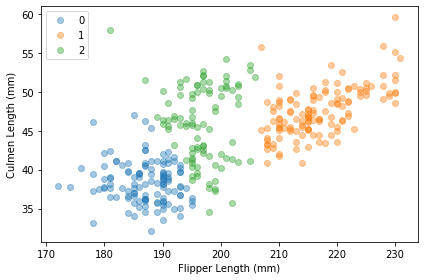

In [27]:
scatterplot(data, var1, var2, 'labels')

The `KMeans` object also contains the centers of the clusters as coordinate pairs in a NumPy array.

In [126]:
kmeans.cluster_centers_

array([[216.88372093,  47.56744186],
       [186.99166667,  38.4275    ],
       [196.7311828 ,  45.95483871]])

To plot the centers, I'll transpose the array and assign the columns to `x` and `y`:

In [127]:
xs, ys = np.transpose(kmeans.cluster_centers_)

I'll plot the centers with x's and o's.

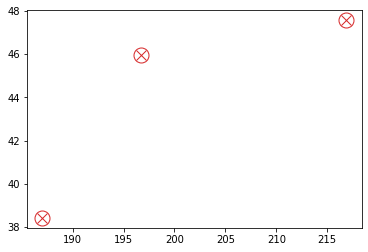

In [130]:
options = dict(color='C3', ls='none', mfc='none')
plt.plot(xs, ys, marker='o', ms=15, **options)
plt.plot(xs, ys, marker='x', ms=10, **options);

As usual, let wrap that up in a function.

In [131]:
def plot_centers(centers, color='C3'):
    """Plot cluster centers.
    
    centers: array with x and y columns
    color: string color specification
    """
    xs, ys = np.transpose(centers)
    options = dict(color=color, ls='none', mfc='none')
    plt.plot(xs, ys, marker='o', ms=15, **options)
    plt.plot(xs, ys, marker='x', ms=10, **options)

And let's put it together.

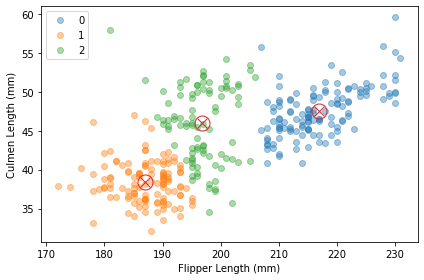

In [132]:
scatterplot(data, var1, var2, 'labels')
plot_centers(kmeans.cluster_centers_)

It looks like k-means does a reasonable job of rediscovering the species, but with some confusion between Adelie (lower left) and Chinstrap (top center).

As a reminder, here are the right answers:

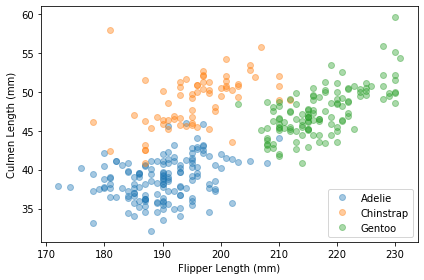

In [133]:
scatterplot(data, var1, var2, 'Species2')

Note that the color coding for the clusters is not consistent because the centers we get from k-means are in a random order.

## Implementing k-means

Now let's see how the algorithm works.  At a high level, there are three steps:

1. Choose $k$ random points in the dataset as initial centers.
2. Assign each point in the dataset to the closest center.
3. Compute new centers by calculating the "center of mass" in each cluster.

Then you repeat steps 2 and 3 until the centers stop moving.

To select random points from the dataset, I'll use `np.random.choice` to select three indices.

In [134]:
index = np.random.choice(len(M), size=3)
index

array([303, 318,  87])

And then use the indices to select rows from the dataset.

In [135]:
centers = M[index]
centers

array([[205. ,  52.8],
       [196. ,  50.9],
       [189. ,  38.3]])

I'll wrap that in a function:

In [137]:
def choose_random_start(M, k):
    """Choose k random elements of M.
    
    M: NumPy array with rows of coordinates
    k: number of centers to choose
    
    returns: NumPy array
    """
    index = np.random.choice(len(M), size=k)
    centers = M[index]
    return centers

Here's how we use it.

In [138]:
centers = choose_random_start(M, 3)
centers

array([[190. ,  35. ],
       [219. ,  44.4],
       [230. ,  59.6]])

And here's what the centers look like on the scatterplot.

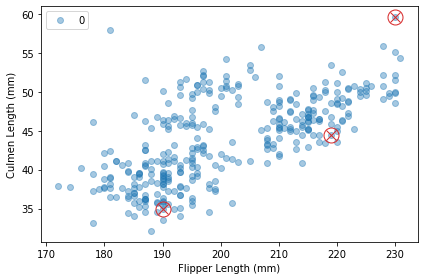

In [139]:
data['labels'] = 0
scatterplot(data, var1, var2, 'labels')
plot_centers(centers)

The next step is to assign each point to the closest center.  So we need to compute the distance between each point and each of the centers.

## Compute distances

To demonstrate the process, I'll pick just one of the centers.

In [101]:
center_x, center_y = centers[0]
center_x, center_y

(193.0, 36.8)

Now it will be convenient to have the `x` and `y` coordinates in separate arrays.  I can do that with `np.transpose`, which turns the columns into rows; then I can assign the rows to `x` and `y`.

In [149]:
x, y = np.transpose(M)
x.shape

(342,)

Along the x-axis, the distance from each point to this center is `x-center_x`.

Along the y-axis, the distance is `y-center_y`.

So the distance between the points is the hypotenuse of the triangle, which I can compute with `np.hypot`:

In [150]:
distances = np.hypot(x-center_x, y-center_y)
distances.shape

(342,)

The result is an array that contains the distance from each point to the chosen center.

To see if we got it right, I'll plot the center and the points, with the size of the points proportional to distance.

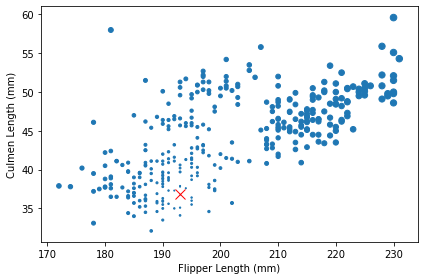

In [151]:
plt.plot(center_x, center_y, 'rx', markersize=10)
plt.scatter(x, y, s=distances)

decorate(xlabel=var1, ylabel=var2)

At least visually, it seems like the size of the points is proportional to their distance from the center.

So let's make that a function:

In [152]:
def compute_distances(M, center):
    """Compute distances to the given center.
    
    M: NumPy array of coordinates
    center: x, y coordinates of the center
    
    returns: NumPy array of float distances
    """
    x, y = np.transpose(M)
    center_x, center_y = center
    distances = np.hypot(x-center_x, y-center_y)
    return distances

We can use that function to make a list of distance arrays, one for each center.

In [153]:
distance_arrays = [compute_distances(M, center)
                   for center in centers]

## Labeling the points

The next step is to find label each point with the index of the center it is closest to.

`distance_arrays` is a list of arrays, but we can convert it to a 2-D array like this:

In [154]:
A = np.array(distance_arrays)
A.shape

(3, 342)

`A` has one row for each center and one column for each point.

Now we can use `np.argmin` to find the shortest distance in each column and return its index.  

In [155]:
data['labels'] = np.argmin(A, axis=0)
data['labels']

0      0
1      0
2      0
4      0
5      0
      ..
339    1
340    0
341    0
342    1
343    0
Name: labels, Length: 342, dtype: int64

The result is an array of indices in the range `0..2`, which we can assign to a column in `data`.

Let's put these steps in a function.

In [156]:
def compute_labels(M, centers):
    """Label each point with the index of the closest center.
    
    M: NumPy array of coordinates
    centers: array of coordinates for the centers
    
    returns: array of labels, 0..k-1
    """
    distance_arrays = [compute_distances(M, center)
                       for center in centers]
    A = np.array(distance_arrays)
    labels = np.argmin(A, axis=0)
    return labels

We can call it like this:

In [157]:
data['labels'] = compute_labels(M, centers)

And here are the results.

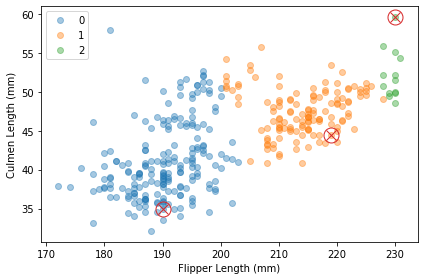

In [158]:
scatterplot(data, var1, var2, 'labels')
plot_centers(centers)

If we get lucky, we might start with one point near the center of each cluster.
But even if we are unlucky, we can improve the results by recentering.

## Find new centers

The last step is to use the labels from the previous step to compute the center of each cluster.

I'll start by using `groupby` to group the points by label.

In [164]:
grouped = data.groupby('labels')
for name, group in grouped:
    print(name, len(group))

0 199
1 130
2 13


We can use the `GroupBy` object to select the columns we're using and compute their means.

In [115]:
data.groupby('labels')[features].mean()

,Flipper Length (mm),Culmen Length (mm)
labels,,
0,189.333333,39.602381
1,217.047619,47.380952
2,199.104167,49.960417


The result is a `DataFrame` that contains the central coordinates of each cluster.

I'll put these steps in a function.

In [165]:
def compute_new_centers(data, features):
    """Compute the center of each cluster.
    
    data: DataFrame
    features: list of string column names
    """
    means = data.groupby('labels')[features].mean()
    return means.to_numpy()

The result is a NumPy array, which we can use as the new centers.

In [166]:
new_centers = compute_new_centers(data, features)
new_centers

array([[190.42713568,  41.0919598 ],
       [214.11538462,  47.42153846],
       [229.46153846,  52.24615385]])

Here's what it looks like with the old centers in gray and the new centers in red.

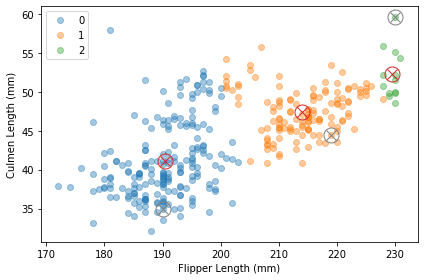

In [167]:
scatterplot(data, var1, var2, 'labels')
plot_centers(centers, color='gray')
plot_centers(new_centers, color='C3')

## The k-means algorithm

Now here's the whole algorithm in one function.

In [168]:
def k_means(data, features, k):
    """Cluster by k means.
    
    data: DataFrame
    features: list of string column names
    k: number of clusters
    
    returns: array of centers
    """
    M = data[features].to_numpy()
    centers = choose_random_start(M, k)

    for i in range(15):
        data['labels'] = compute_labels(M, centers)
        centers = compute_new_centers(data, features)

    return centers

And here's what the results look like after 15 iterations.

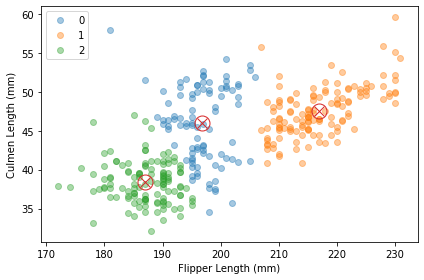

In [169]:
centers = k_means(data, features, 3)
scatterplot(data, var1, var2, 'labels')
plot_centers(centers, color='C3')

The results are (as far as I can see) identical to what we got from the scikit-learn implementation.

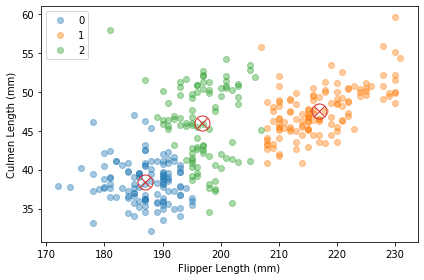

In [172]:
kmeans = KMeans(n_clusters=3).fit(M)
data['labels'] = kmeans.labels_

scatterplot(data, var1, var2, 'labels')
plot_centers(kmeans.cluster_centers_)

Here's an animation that shows the algorithm in action.

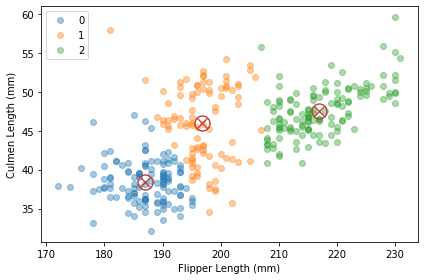

In [174]:
from time import sleep
from IPython.display import clear_output
interval = 1

centers = choose_random_start(M, k=3)
plt.figure()

for i in range(10):
    # label and scatter plot
    data['labels'] = compute_labels(M, centers)
    scatterplot(data, var1, var2, 'labels')
    plot_centers(centers, color='gray')
        
    # compute new centers and plot them
    new_centers = compute_new_centers(data, features)        
    plot_centers(new_centers)
    centers = new_centers
        
    # show the plot, wait, and clear
    plt.show()
    sleep(interval)        
    clear_output(wait=True)

## Number of clusters

All of this is based on the assumption that you know how many clusters you are looking for, which is true for some applications, but not always.

Let's see what goes wrong if you ask for too many clusters, or too few.

**Exercise:** Run the following code with different values of `n_clusters` and see what the results look like.

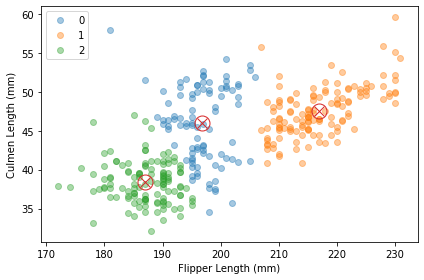

In [175]:
kmeans = KMeans(n_clusters=3).fit(M)
data['labels'] = kmeans.labels_

scatterplot(data, var1, var2, 'labels')
plot_centers(kmeans.cluster_centers_)

## Standarization

One of the problems with the results we have seen so far is that the lines between the clusters are mostly vertical.

That's because the range of values is wider for flipper length than culmen length, about 60 mm compared to 28 mm.

In [176]:
M.max(axis=0) - M.min(axis=0)

array([59. , 27.5])

So when we compute the distance from each point to each center, the distances in the $x$ direction tend to dominate.

This is a common problem with algorithms that are based on distance in multidimensional space.

In fact, it is such a common problem that there is a common solution: [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling).

The goal of feature scaling is to transform the inputs to the algorithm so the distances along each axis are comparable.

One version of feature scaling is "standardization", which consists of

1. Subtracting the mean from each feature, and
2. Dividing through by the standard deviation.

Here's how we can do it with the features in `M`:

In [59]:
means = M.mean(axis=0)
means

array([200.91520468,  43.92192982])

In [177]:
stds = M.std(axis=0)
stds

array([14.04114057,  5.45159602])

In [61]:
M_std = (M - means) / stds

Now let's see what happens if we run the algorithm again with standardized features.

Notice that I have to transform the centers back before plotting them.

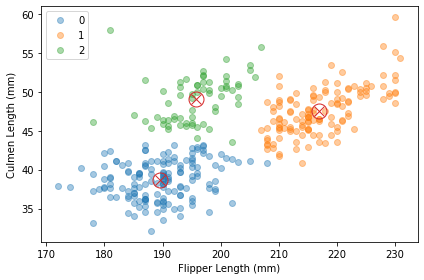

In [182]:
kmeans = KMeans(n_clusters=3).fit(M_std)
data['labels'] = kmeans.labels_

scatterplot(data, var1, var2, 'labels')

centers = kmeans.cluster_centers_ * stds + means
plot_centers(centers)


And that looks a lot better!  One more time, here are the actual species for comparison.

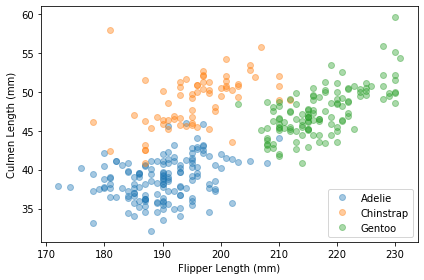

In [181]:
scatterplot(data, var1, var2, 'Species2')

scikit-learn provides `StandardScaler`, which does the same thing.

In [179]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(M)
M_std = scaler.transform(M)

And `scaler` provides `inverse_transform`, which we can use to transform the centers back.

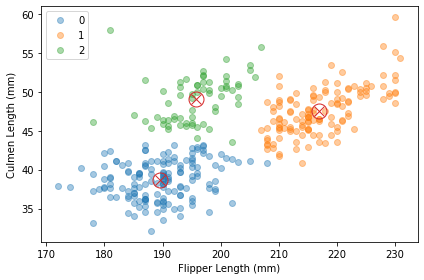

In [180]:
kmeans = KMeans(n_clusters=3).fit(M_std)
data['labels'] = kmeans.labels_

scatterplot(data, var1, var2, 'labels')

centers = scaler.inverse_transform(kmeans.cluster_centers_)
plot_centers(centers)

## Summary

